In [3]:
import math
import torch
import pyro
import tqdm
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [7]:
intensity_max = 50
true_intensity_function = lambda times: torch.cos(times * 2 * math.pi).add(1).mul(intensity_max / 2.)

In [8]:
max_time = 2

times = torch.linspace(0, max_time, 128)
num_samples = int(pyro.distributions.Poisson(true_intensity_function(times).mean() * max_time).sample().item())
print(f"Number of sampled arrivals: {num_samples}")

Number of sampled arrivals: 50


In [9]:
def log_prob_accept(val):
    intensities = true_intensity_function(val)
    res = torch.log(intensities / (true_intensity_function(times).mean() * max_time))
    return res

arrival_times = pyro.distributions.Rejector(
    propose=pyro.distributions.Uniform(times.min(), times.max()),
    log_prob_accept=log_prob_accept,
    log_scale=0.
)(torch.Size([num_samples]))

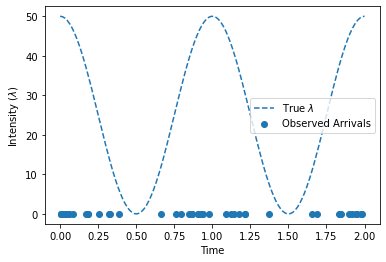

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(times, true_intensity_function(times), "--", label=r"True $\lambda$")
ax.set_xlabel("Time")
ax.set_ylabel("Intensity ($\lambda$)")
ax.scatter(arrival_times, torch.zeros_like(arrival_times), label=r"Observed Arrivals")
ax.legend(loc="best")
None

In [41]:
arrival_times.log()

tensor([-0.4382, -0.1743,  0.6271,  0.1634,  0.0730,  0.1451,  0.6528, -0.2763,
         0.3038,  0.6353,  0.5710,  0.2882, -0.4527,  0.5850, -1.2716,  0.5787,
        -1.0201, -0.0902, -1.5452,  0.6423, -2.2123,  0.1847,  0.1630, -0.0491,
         0.1402,  0.5290, -1.8137, -6.4122, -1.2050, -0.0583,  0.2432, -0.0624,
        -0.2300, -2.2876,  0.1834,  0.2225, -1.4369,  0.6873, -1.2175, -0.0141,
         0.0290,  0.3345, -1.7572,  0.0442, -0.3495, -0.0773,  0.5506,  0.6838,
         0.1673, -0.0144, -3.4296,  0.1043,  0.6678,  0.2266, -0.1902,  0.5293])

In [42]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_arrivals, max_time, num_inducing=32, name_prefix="cox_gp_model"):
        self.name_prefix = name_prefix
        self.max_time = max_time
        self.mean_intensity = (num_arrivals / max_time)
        
        # Define the variational distribution and strategy of the GP
        # We will initialize the inducing points to lie on a grid from 0 to T
        inducing_points = torch.linspace(0, max_time, num_inducing).unsqueeze(-1)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=num_inducing)
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution)

        # Define model
        super().__init__(variational_strategy=variational_strategy)

        # Define mean and kernel
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, times):
        mean = self.mean_module(times)
        covar = self.covar_module(times)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, arrival_times, quadrature_times):
        # Draw samples from q(f) at arrival_times
        # Also draw samples from q(f) at evenly-spaced points (quadrature_times)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            pyro.sample(
                self.name_prefix + ".function_samples",
                self.pyro_guide(torch.cat([arrival_times, quadrature_times], -1))
            )

    def model(self, arrival_times, quadrature_times):
        pyro.module(self.name_prefix + ".gp", self)
        
        # Draw samples from p(f) at arrival times
        # Also draw samples from p(f) at evenly-spaced points (quadrature_times)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            function_samples = pyro.sample(
                self.name_prefix + ".function_samples",
                self.pyro_model(torch.cat([arrival_times, quadrature_times], -1))
            )
        
        ####
        # Convert function samples into intensity samples, using the function above
        ####
        intensity_samples = function_samples.exp() * self.mean_intensity
        
        # Divide the intensity samples into arrival_intensity_samples and quadrature_intensity_samples
        arrival_intensity_samples, quadrature_intensity_samples = intensity_samples.split([
            arrival_times.size(-1), quadrature_times.size(-1)
        ], dim=-1)

        ####
        # Compute the log_likelihood, using the method described above
        ####
        arrival_log_intensities = arrival_intensity_samples.log().sum(dim=-1)
        est_num_arrivals = quadrature_intensity_samples.mean(dim=-1).mul(self.max_time)
        log_likelihood = arrival_log_intensities - est_num_arrivals
        pyro.factor(self.name_prefix + ".log_likelihood", log_likelihood)

In [43]:
model = GPModel(arrival_times.numel(), max_time)

In [46]:
model.name_prefix

'cox_gp_model'

In [47]:
quadrature_times = torch.linspace(0, max_time, 64)

In [48]:
num_iter = 200
num_particles = 32


def train(lr=0.01):
    optimizer = pyro.optim.Adam({"lr": lr})
    loss = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    infer = pyro.infer.SVI(model.model, model.guide, optimizer, loss=loss)

    model.train()
    loader = tqdm.notebook.tqdm(range(num_iter))
    for i in loader:
        loss = infer.step(arrival_times, quadrature_times)
        loader.set_postfix(loss=loss)
        
train()

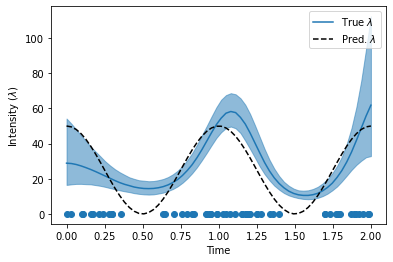

In [49]:
# Get the average predicted intensity function, and the intensity confidence region
model.eval()
with torch.no_grad():
    function_dist = model(quadrature_times)
    intensity_samples = function_dist(torch.Size([1000])).exp() * model.mean_intensity
    lower, mean, upper = percentiles_from_samples(intensity_samples)

# Plot the predicted intensity function
fig, ax = plt.subplots(1, 1)
line, = ax.plot(quadrature_times, mean, label=r"True $\lambda$")
ax.fill_between(quadrature_times, lower, upper, color=line.get_color(), alpha=0.5)
ax.plot(quadrature_times, true_intensity_function(quadrature_times), "--", color="k", label=r"Pred. $\lambda$")
ax.legend(loc="best")
ax.set_xlabel("Time")
ax.set_ylabel("Intensity ($\lambda$)")
ax.scatter(arrival_times, torch.zeros_like(arrival_times), label=r"Observed Arrivals")
None

Text(0.5, 1.0, 'Samples from exp. distrib.')

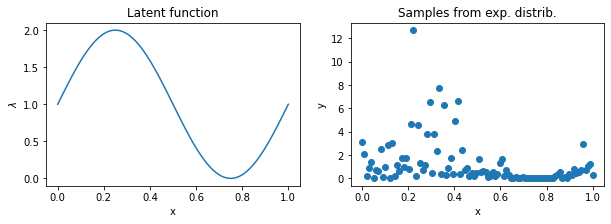

In [2]:
# Here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2 * math.pi * x) + 1 

# Generate synthetic data
# here we generate some synthetic samples
NSamp = 100

X = np.linspace(0, 1, 100) 

fig, (lambdaf, samples) = plt.subplots(1, 2, figsize=(10, 3))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

Y = np.zeros_like(X)
for i,x in enumerate(X):
    Y[i] = np.random.exponential(scale(x), 1)
samples.scatter(X,Y)
samples.set_xlabel('x')
samples.set_ylabel('y')
samples.set_title('Samples from exp. distrib.')

In [3]:
train_x = torch.tensor(X).float()
train_y = torch.tensor(Y).float()

In [4]:
class PVGPRegressionModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_inducing=64, name_prefix="mixture_gp"):
        self.name_prefix = name_prefix
        
        # Define all the variational stuff
        inducing_points = torch.linspace(0, 1, num_inducing)
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points,
            gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=num_inducing)
        )
        
        # Standard initializtation
        super().__init__(variational_strategy)
        
        # Mean, covar, likelihood
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)
    
    def guide(self, x, y):
        # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x)

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            pyro.sample(self.name_prefix + ".f(x)", function_dist)
    
    def model(self, x, y):
        pyro.module(self.name_prefix + ".gp", self)
        
        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x)
        
        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            function_samples = pyro.sample(self.name_prefix + ".f(x)", function_dist)
            
            # Use the link function to convert GP samples into scale samples
            scale_samples = function_samples.exp()

            # Sample from observed distribution
            return pyro.sample(
                self.name_prefix + ".y",
                pyro.distributions.Exponential(scale_samples.reciprocal()),  # rate = 1 / scale
                obs=y
            )

In [5]:
model = PVGPRegressionModel()

In [6]:
model

PVGPRegressionModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): CholeskyVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [7]:
num_iter =  200
num_particles = 256


def train():
    optimizer = pyro.optim.Adam({"lr": 0.1})
    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

    model.train()
    iterator = tqdm.notebook.tqdm(range(num_iter))
    for i in iterator:
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        iterator.set_postfix(loss=loss, lengthscale=model.covar_module.base_kernel.lengthscale.item())
        
%time train()


CPU times: user 10.6 s, sys: 1.47 s, total: 12.1 s
Wall time: 12 s


In [8]:
# Here's a quick helper function for getting smoothed percentile values from samples
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]
    
    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]
    
    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]
    
    return percentile_samples

In [9]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
test_x = torch.linspace(0, 1, denser * NSamp).float()#.cuda()

model.eval()
with torch.no_grad():
    output = model(test_x)

# Get E[exp(f)] via f_i ~ GP, 1/n \sum_{i=1}^{n} exp(f_i).
# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([1000])).exp()
lower, mean, upper = percentiles_from_samples(samples)

# Draw some simulated y values
scale_sim = model(train_x)().exp()
y_sim = pyro.distributions.Exponential(scale_sim.reciprocal())()

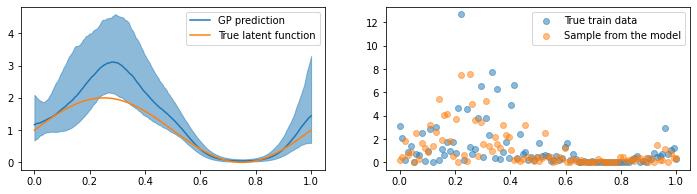

In [10]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean.detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower.detach().cpu().numpy(),
    upper.detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, scale(test_x), label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y, alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim.cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

In [14]:
output(torch.Size([1000]))

tensor([[ 0.4005,  0.3461,  0.3333,  ..., -0.0073,  0.0088,  0.0495],
        [ 0.2563,  0.2409,  0.2312,  ...,  0.7215,  0.7878,  0.8600],
        [ 0.3617,  0.3283,  0.2943,  ...,  0.9873,  1.0110,  1.0703],
        ...,
        [ 0.3549,  0.3664,  0.3693,  ...,  0.6913,  0.7835,  0.8741],
        [ 0.3247,  0.3727,  0.4386,  ...,  0.7192,  0.7715,  0.8349],
        [-0.3389, -0.2877, -0.2504,  ...,  0.3790,  0.3862,  0.3588]])

In [8]:
class PVGPRegressionModel(gpytorch.models.PyroGP): # extends ApproximateGP
    def __init__(self, train_x, train_y, likelihood):
        # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=train_y.numel(),
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution
        )
        
        # Standard initializtation
        super(PVGPRegressionModel, self).__init__(
            variational_strategy,
            likelihood,
            num_data=train_y.numel(),
            name_prefix="simple_regression_model"
        )
        self.likelihood = likelihood
        
        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5)
        )

    def forward(self, x):
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [9]:
model = PVGPRegressionModel(train_x, train_y, gpytorch.likelihoods.GaussianLikelihood())

In [46]:
num_iter =  200
num_particles = 256


def train(lr=0.01):
    optimizer = pyro.optim.Adam({"lr": 0.1})
    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    for i in range(num_iter):
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        
%time train()

CPU times: user 4.18 s, sys: 50.1 ms, total: 4.23 s
Wall time: 4.22 s


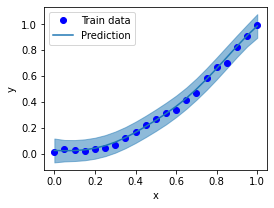

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
train_data, = ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'bo')

model.eval()
with torch.no_grad():
    output = model.likelihood(model(train_x))
    
mean = output.mean
lower, upper = output.confidence_region()
line, = ax.plot(train_x.cpu().numpy(), mean.detach().cpu().numpy())
ax.fill_between(train_x.cpu().numpy(), lower.detach().cpu().numpy(),
                upper.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend([train_data, line], ['Train data', 'Prediction'])

In [4]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [6]:
train_y

tensor([-0.3888,  0.1062,  0.1720,  0.3088,  0.3153,  0.7004,  0.3169,  0.3134,
         0.6458,  0.5865,  0.7845,  0.7180,  0.5347,  0.6678,  0.7350,  0.6745,
         0.4440,  0.8236,  0.6777,  0.7538,  0.8588,  1.0900,  0.8827,  0.8525,
         1.2782,  1.1655,  1.2833,  1.1497,  0.9375,  0.6757,  0.8094,  0.8677,
         0.9165,  1.0770,  1.1480,  1.0601,  0.8876,  0.7361,  0.6804,  1.0950,
         0.9156,  0.0230,  0.1343,  0.1686,  0.4540,  0.0921, -0.0786,  0.1359,
         0.1732, -0.0294, -0.2454, -0.1663, -0.2316, -0.1959, -0.3841, -0.5511,
        -0.7394, -0.6092, -0.5471, -0.3774, -0.7676, -0.8666, -0.5653, -0.7512,
        -0.3482, -0.6306, -0.8168, -0.9884, -0.8337, -1.1502, -0.8521, -0.6202,
        -1.2541, -0.8980, -1.0110, -1.0329, -1.0285, -1.0066, -1.0002, -1.2691,
        -0.8186, -0.6450, -0.5300, -0.7876, -0.7283, -0.7045, -0.3712, -0.8557,
        -0.4156, -0.6359, -0.4898, -0.7475, -0.2900, -0.2156, -0.3003,  0.0895,
        -0.0522, -0.3796,  0.1091,  0.03

In [13]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP): # heriditary from ExactGP class
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [14]:
from gpytorch.priors import LogNormalPrior, NormalPrior, UniformPrior
# Use a positive constraint instead of usual GreaterThan(1e-4) so that LogNormal has support over full range.
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
model = ExactGPModel(train_x, train_y, likelihood)

model.mean_module.register_prior("mean_prior", UniformPrior(-1, 1), "constant")
model.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.01, 0.5), "lengthscale")
model.covar_module.base_kernel.register_prior("period_length_prior", UniformPrior(0.05, 2.5), "period_length")
model.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
likelihood.register_prior("noise_prior", UniformPrior(0.05, 0.3), "noise")

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [18]:
def pyro_model(x, y):
    model.pyro_sample_from_prior()
    output = model(x)
    loss = mll.pyro_factor(output, y)
    return y

In [22]:
nuts_kernel = NUTS(pyro_model, adapt_step_size=True)

In [25]:
mcmc_run = MCMC(nuts_kernel, num_samples=100, warmup_steps=200, disable_progbar=False)
mcmc_run.run(train_x, train_y)

Sample: 100%|██████████| 300/300 [11:05,  2.22s/it, step size=1.44e-02, acc. prob=0.816]


In [26]:
model.pyro_load_from_samples(mcmc_run.get_samples())

In [31]:
model.eval()
test_x = torch.linspace(0, 1, 101).unsqueeze(-1)
test_y = torch.sin(test_x * (2 * math.pi))
expanded_test_x = test_x.unsqueeze(0).repeat(100, 1, 1)
output = model(expanded_test_x)

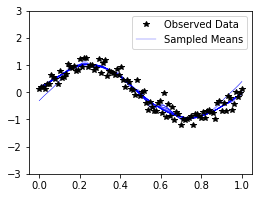

In [32]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', zorder=10)
    
    for i in range(min(100, 25)):
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), output.mean[i].detach().numpy(), 'b', linewidth=0.3)
        
    # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Sampled Means'])

In [13]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

In [14]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)

In [17]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [18]:
mll

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): ExactGPModel(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [20]:
training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.959   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.928   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.894   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.856   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.812   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.762   lengthscale: 0.476   noise: 0.474
Iter 7/50 - Loss: 0.707   lengthscale: 0.440   noise: 0.437
Iter 8/50 - Loss: 0.650   lengthscale: 0.405   noise: 0.402
Iter 9/50 - Loss: 0.596   lengthscale: 0.373   noise: 0.369
Iter 10/50 - Loss: 0.546   lengthscale: 0.343   noise: 0.339
Iter 11/50 - Loss: 0.501   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.461   lengthscale: 0.292   noise: 0.283
Iter 13/50 - Loss: 0.424   lengthscale: 0.271   noise: 0.259
Iter 14/50 - Loss: 0.388   lengthscale: 0.254   noise: 0.236
Iter 15/50 - Loss: 0.353   lengthscale: 0.240   noise: 0.215
Iter 16/50 - Loss: 0.319   lengthscale: 0.229   noise: 0.195
Iter 17/50 - Loss: 0.285   length

In [21]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    # model(test_x)
    observed_pred = likelihood(model(test_x))

In [29]:
observed_pred.mean
observed_pred.variance
observed_pred.covariance_matrix

tensor([[ 3.5149e-02,  4.8796e-03,  3.5326e-03,  ..., -4.3650e-05,
         -4.1567e-05, -2.8005e-05],
        [ 4.8796e-03,  3.2702e-02,  3.0792e-03,  ..., -2.3637e-05,
         -3.4804e-05, -4.1542e-05],
        [ 3.5326e-03,  3.0792e-03,  3.1377e-02,  ..., -5.0873e-06,
         -2.3654e-05, -4.3625e-05],
        ...,
        [-4.3649e-05, -2.3638e-05, -5.0883e-06,  ...,  3.1378e-02,
          3.0797e-03,  3.5332e-03],
        [-4.1567e-05, -3.4804e-05, -2.3655e-05,  ...,  3.0797e-03,
          3.2702e-02,  4.8800e-03],
        [-2.8005e-05, -4.1541e-05, -4.3625e-05,  ...,  3.5332e-03,
          4.8800e-03,  3.5149e-02]])

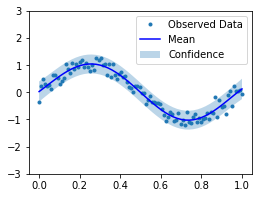

In [36]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), '.')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [34]:
observed_pred.confidence_region()

(tensor([-0.3499, -0.2240, -0.1021,  0.0156,  0.1287,  0.2360,  0.3361,  0.4272,
          0.5075,  0.5752,  0.6288,  0.6670,  0.6888,  0.6938,  0.6817,  0.6526,
          0.6070,  0.5455,  0.4692,  0.3792,  0.2771,  0.1645,  0.0432, -0.0848,
         -0.2173, -0.3523, -0.4874, -0.6203, -0.7487, -0.8704, -0.9832, -1.0850,
         -1.1738, -1.2480, -1.3060, -1.3469, -1.3697, -1.3740, -1.3599, -1.3277,
         -1.2782, -1.2125, -1.1321, -1.0388, -0.9347, -0.8224, -0.7046, -0.5847,
         -0.4665, -0.3542, -0.2521]),
 tensor([ 0.4001,  0.4993,  0.6064,  0.7170,  0.8274,  0.9341,  1.0341,  1.1251,
          1.2050,  1.2721,  1.3251,  1.3627,  1.3842,  1.3889,  1.3767,  1.3476,
          1.3019,  1.2405,  1.1641,  1.0740,  0.9719,  0.8592,  0.7378,  0.6098,
          0.4772,  0.3422,  0.2071,  0.0743, -0.0541, -0.1758, -0.2885, -0.3901,
         -0.4789, -0.5530, -0.6111, -0.6519, -0.6747, -0.6789, -0.6646, -0.6320,
         -0.5819, -0.5156, -0.4346, -0.3409, -0.2367, -0.1243, -0.0059,

In [34]:
torch.cuda.is_available()

False

In [ ]:
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()